In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py
import torch
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
np.set_printoptions(precision=2, suppress=False)

Building dataset with constant housing in time


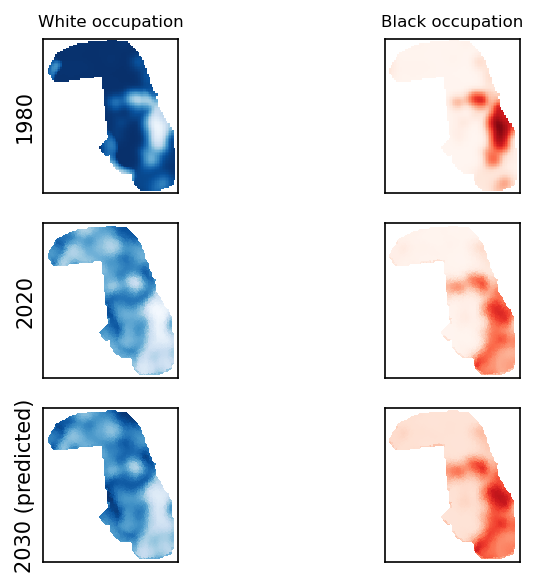

In [60]:
from data_processing import CensusDataset, scalar_img_to_mesh
import ufl
import dolfin as dlf
import dolfin_adjoint as d_ad
import pyadjoint as pyad

dlf.set_log_level(40)


def plot_mesh(ax, f, mesh, lw=False, scale=1, vmin=0, vmax=1, **kwargs):
    x, y = mesh.coordinates()[:, 0], mesh.coordinates()[:, 1]
    tri = mesh.cells()
    if lw:
        kwargs['edgecolors'] = 'black'
        kwargs['linewidth'] = 0.05
    if not isinstance(f, np.ndarray):
        ax.tripcolor(x, y, f.compute_vertex_values() * scale, triangles=tri, vmin=vmin, vmax=vmax, **kwargs)
    else:
        ax.tripcolor(x, y, f * scale, triangles=tri, vmin=vmin, vmax=vmax, **kwargs)
    ax.set(xticks=[], yticks=[])


class DerivativeDataset(CensusDataset):
    def get_dolfin(self, sample):
        '''
        Generate reduced functional for calculating dJ/dD
        Following github.com/schmittms/physical_bottleneck
        '''
        D_init = np.ones_like(self.x)
        el = ufl.FiniteElement('CG', self.mesh.ufl_cell(), 1)
        V  = dlf.FunctionSpace(self.mesh, el)    #W/B function space
        VV = dlf.FunctionSpace(self.mesh, el*el)
        
        def forward(Dww, Dbb, dt, w0, b0, mesh):
            '''Solve forward problem for given diffusion coefficients and Gamma terms'''
            w, b = dlf.TrialFunctions(VV)
            u, v = dlf.TestFunctions(VV)
            
            #dt(\phi_i) - D_{ii} = 0
            #Note that Danny's paper uses the opposite sign on Dij
            a = w*u*ufl.dx + b*v*ufl.dx
            L = w0*u*ufl.dx + b0*v*ufl.dx
            L += dt * Dww * u * ufl.dx
            L += dt * Dbb * v * ufl.dx
            
            wb = d_ad.Function(VV)
            d_ad.solve(a == L, wb)
            return wb, a, L
            
        dt = d_ad.Constant(sample['dt'], name='dt')
        
        Dij_init = np.zeros([2, *self.x.shape])
        Dij_init[:, sample['mask']] = 1

        Dww = scalar_img_to_mesh(Dij_init[0], self.x, self.y, V)
        Dbb = scalar_img_to_mesh(Dij_init[1], self.x, self.y, V)
        w0 = scalar_img_to_mesh(sample['wb0'][0], self.x, self.y, V)
        b0 = scalar_img_to_mesh(sample['wb0'][1], self.x, self.y, V)
        
        w1 = scalar_img_to_mesh(sample['wb1'][0], self.x, self.y, V)
        b1 = scalar_img_to_mesh(sample['wb1'][1], self.x, self.y, V)
                
        wb, a, L = forward(Dww, Dbb, dt, w0, b0, self.mesh)
        w, b = wb.split(True)
        J = d_ad.assemble(ufl.dot(w - w1, w - w1) * ufl.dx + \
                          ufl.dot(b - b1, b - b1) * ufl.dx)
        
        #Build controls to allow for updating values
        control_Dww = d_ad.Control(Dww) 
        control_Dbb = d_ad.Control(Dbb)
        control_dt = d_ad.Control(dt)
        control_w0 = d_ad.Control(w0)
        control_b0 = d_ad.Control(b0)
        
        controls = [control_Dww, control_Dbb, control_dt, control_w0, control_b0]
        Jhat_np = pyad.ReducedFunctionalNumPy(J, controls)
        Jhat =    pyad.ReducedFunctional(J, controls)
        
        control_arr = [p.data() for p in Jhat_np.controls]
        control_arr = Jhat_np.obj_to_array(control_arr)
        
        return {
            'Jhat': Jhat_np,
            'control_arr': control_arr,
            'pde_forward': forward,
            'FctSpace': V,
            'base_RF': Jhat,
            'J': J,
            'Dij': torch.FloatTensor(Dij_init),
        }
    

county = 'cook_IL'
dataset = DerivativeDataset(county, housing_method='constant')
dataset.validate()

fig, ax = plt.subplots(3, 2, dpi=150, sharey=True, sharex=True)

sample = dataset.get_time(1980)
ax[0,0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=1, vmin=0)
ax[0,1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=1, vmin=0)

sample = dataset[30]

#Generate fields on mesh
V = sample['FctSpace']
N = V.dim()
Dww = d_ad.Function(V)
Dbb = d_ad.Function(V)
w0 = d_ad.Function(V)
b0 = d_ad.Function(V)

Dww.vector()[:] = sample['control_arr'][0*N:1*N]
Dbb.vector()[:] = sample['control_arr'][1*N:2*N]

dt = d_ad.Constant(sample['dt'], name='dt')
w0 = scalar_img_to_mesh(sample['wb0'][0], sample['x'], sample['y'], sample['FctSpace'])
b0 = scalar_img_to_mesh(sample['wb0'][1], sample['x'], sample['y'], sample['FctSpace'])
#w0.vector()[:] = sample['control_arr'][4*N+3:5*N+3]
#b0.vector()[:] = sample['control_arr'][5*N+3:6*N+3]

wb, _, _ = sample['pde_forward'](Dww, Dbb, .1, w0, b0, dataset.mesh)
w1, b1 = wb.split(True)

plot_mesh(ax[1,0], w0, dataset.mesh, cmap='Blues')
plot_mesh(ax[1,1], b0, dataset.mesh, cmap='Reds')

plot_mesh(ax[2,0], w1, dataset.mesh, cmap='Blues')
plot_mesh(ax[2,1], b1, dataset.mesh, cmap='Reds')

ax[0,0].set_title('White occupation', fontsize=8)
ax[0,1].set_title('Black occupation', fontsize=8)
ax[0,0].set_ylabel('1980')
ax[1,0].set_ylabel('2020')
ax[2,0].set_ylabel('2030 (predicted)')
for a in ax.flatten():
    a.set_aspect('equal')
    a.set(xticks=[], yticks=[])
plt.tight_layout()


In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pbnn import ConvNextBlock

from torchvision import transforms
from data_processing import scalar_img_to_mesh, mesh_to_scalar_img

import dolfin as dlf
import dolfin_adjoint as d_ad
from tqdm.auto import trange

class IntegrablePBNN(nn.Module):
    '''
    CNN computes local diffusion matrix from phi_W/B inputs
    The restriction is that Gamma is positive and there is 
        no further restriction on D_{ij}
    '''
    def __init__(self,
                 kernel_size=7,
                 N_hidden=8,
                 hidden_size=64):
        super().__init__()

        self.kernel_size = kernel_size
        self.N_hidden = N_hidden
        self.hidden_size = hidden_size

        self.read_in = ConvNextBlock(2, hidden_size, kernel_size)
        self.read_out = nn.Conv2d(hidden_size, 2, kernel_size=1)
        self.cnn = nn.ModuleList()
        for i in range(N_hidden):
            self.cnn.append(ConvNextBlock(hidden_size, hidden_size, kernel_size))

        self.blur = transforms.GaussianBlur(kernel_size, sigma=1)
        self.device = torch.device('cpu')        

    def training_step(self, sample):
        Dij, Dij_mesh = self.forward(sample['wb0'][None], 
                                     sample['FctSpace'], 
                                     (sample['x'], sample['y']))
        N = sample['FctSpace'].dim()
        D = len(Dij_mesh)

        Dij_mesh = Dij_mesh.flatten()
        control_arr = sample['control_arr'].copy()
        control_arr[:D*N] = Dij_mesh.detach().cpu().numpy()
        control_arr[D*N] = sample['dt']

        J = sample['Jhat'](control_arr)
        dJdD = sample['Jhat'].derivative(control_arr, forget=True, project=False)
        grad = torch.tensor(dJdD, device=Dij.device) / sample['dt']

        Dij_mesh.backward(gradient=grad[:D*N])

        return Dij, Dij_mesh, J, dJdD

    def validation_step(self, sample):
        Dij, Dij_mesh = self.forward(sample['wb0'][None], 
                                     sample['FctSpace'], 
                                     (sample['x'], sample['y']))
        N = sample['FctSpace'].dim()
        D = len(Dij_mesh)

        Dij_mesh = Dij_mesh.flatten()
        control_arr = sample['control_arr'].copy()
        control_arr[:D*N] = Dij_mesh.detach().cpu().numpy()
        control_arr[D*N] = sample['dt']

        J = sample['Jhat'](control_arr)

        return Dij, Dij_mesh, J

    def forward(self, wb0, FctSpace=None, xy=None):
        wb0[wb0.isnan()] = 0
        D = self.read_in(wb0)
        for cell in self.cnn:
            D = D + cell(D)
        Dij = self.read_out(D).squeeze()
        Dij = self.blur(Dij)

        if FctSpace is not None:
            assert xy is not None
            Dij_mesh = torch.zeros([Dij.shape[0], FctSpace.dim()], 
                                   dtype=Dij.dtype, device=Dij.device)
            for i in range(Dij.shape[0]):
                Dij_mesh[i] = scalar_img_to_mesh(Dij[i], *xy, FctSpace, vals_only=True)

            return Dij, Dij_mesh

        return Dij, None

    def simulate(self, sample, mesh, tmax, dt=0.1):
        FctSpace = sample['FctSpace']
        N = FctSpace.dim()
        Dww = d_ad.Function(FctSpace)
        Dbb = d_ad.Function(FctSpace)
        w0 = scalar_img_to_mesh(sample['wb0'][0], sample['x'], sample['y'], sample['FctSpace'])
        b0 = scalar_img_to_mesh(sample['wb0'][1], sample['x'], sample['y'], sample['FctSpace'])

        Dt = d_ad.Constant(dt)
        x_verts = mesh.coordinates()[0]
        y_verts = mesh.coordinates()[1]
        x_img = sample['x']
        y_img = sample['y']
        mask = sample['mask']

        #Interpolate w0, b0 to grid
        w_img = mesh_to_scalar_img(w0, mesh, x_img, y_img, mask)
        b_img = mesh_to_scalar_img(b0, mesh, x_img, y_img, mask)
        wb = torch.FloatTensor(np.stack([w_img, b_img])).to(sample['wb0'].device)

        steps = int(np.round(tmax / dt))
        for i in trange(steps):
            #Run PBNN to get Dij, constants and assign to variational parameters
            _, Dij = self.forward(wb[None], sample['FctSpace'], (sample['x'], sample['y']))
            Dij = Dij.detach().cpu().numpy()
            Dww.vector()[:] = Dij[0]
            Dbb.vector()[:] = Dij[1]

            #Solve variational problem and update w0, b0
            wb, _, _ = sample['pde_forward'](Dww, Dbb, Dt, w0, b0, mesh)
            w, b = wb.split(True)
            w0.assign(w)
            b0.assign(b)

            #Interpolate w0, b0 to grid
            w_img = mesh_to_scalar_img(w0, mesh, x_img, y_img, mask)
            b_img = mesh_to_scalar_img(b0, mesh, x_img, y_img, mask)
            wb = torch.FloatTensor(np.stack([w_img, b_img])).to(sample['wb0'].device)

        return w0, b0, wb


savedir = '.'
n_epochs = 100
batch_size = 8

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = IntegrablePBNN().to(device)

opt = torch.optim.Adam(model.parameters(), lr=3e-4)
sch = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.99)
train_loss = []
val_loss = []
step = 0
with tqdm(total=n_epochs) as pbar:
    for epoch in range(n_epochs):
        dataset.training()
        d_ad.set_working_tape(d_ad.Tape())

        with tqdm(total=len(dataset), leave=False) as ebar:
            for i in range(len(dataset)):
                batch = dataset[i]
                batch['wb0'] = batch['wb0'].to(device)

                Dij, Dij_mesh, J, dJdD = model.training_step(batch)
                train_loss.append(J)
                step += 1
                ebar.update()

                if step % batch_size == 0:
                    ebar.set_postfix(running_loss=np.mean(train_loss[-batch_size:]))

                    opt.step()
                    d_ad.set_working_tape(d_ad.Tape())
                    opt.zero_grad()

        dataset.validate()
        val_loss.append(0)

        with tqdm(total=len(dataset), leave=False) as ebar:
            with torch.no_grad():
                for i in range(len(dataset)):
                    d_ad.set_working_tape(d_ad.Tape())

                    batch = dataset[i]
                    batch['wb0'] = batch['wb0'].to(device)

                    Dij, Dij_mesh, J = model.validation_step(batch)
                    val_loss[epoch] += J
                    ebar.update()
                    
        pbar.set_postfix(val_loss=val_loss[-1])


        torch.save(
            {
                'state_dict': model.state_dict(),
                'val_loss': val_loss,
                'train_loss': train_loss,
            },
            f'{savedir}/{model.__class__.__name__}.ckpt')

        sch.step()
        pbar.update()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Using vmax = 0.0185972
Using vmax = 0.0227547


  0%|          | 0/400 [00:00<?, ?it/s]

Using vmax = 0.0282897
Difference after 40 years is: 0.0315392


Text(0.5, 1.0, '$\\partial_t \\phi_b$')

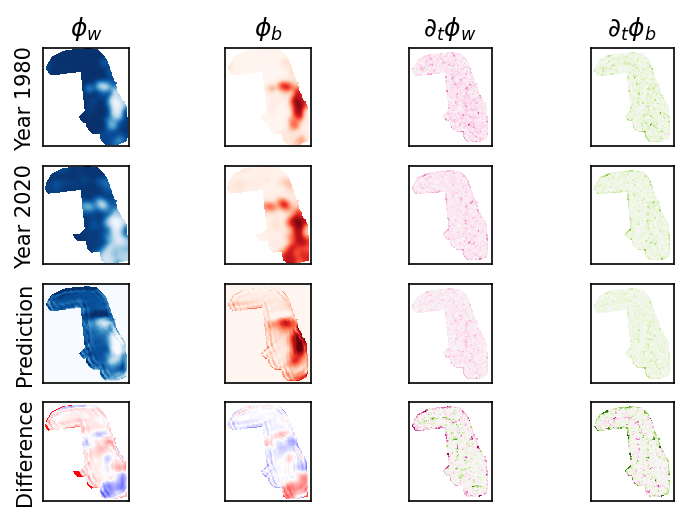

In [59]:
def plot(ax, sample, model, vmax=None):
    ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=1, vmin=0)
    ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=1, vmin=0)

    with torch.no_grad(), d_ad.stop_annotating():
        sample['wb0'] = sample['wb0'].to(device)
        Dij, Dij_mesh = model.forward(sample['wb0'][None],
                                      sample['FctSpace'],
                                      (sample['x'], sample['y']))
        Dij = Dij_mesh.reshape([2, -1])
        Dij = Dij.detach().cpu().numpy()
    
    if vmax is None:
        vmax = np.max(np.abs(Dij))
        print(f'Using vmax = {vmax:g}')

    for i in range(2):
        plot_mesh(ax[2+i], Dij[i], dataset.mesh, cmap='PiYG', vmin=-vmax, vmax=vmax)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    
    ax[0].set_ylabel(f'Year {sample["t"]:g}')
    
    return sample['wb0'].detach().cpu().numpy(), Dij
        
model = IntegrablePBNN().to(device)
info = torch.load('IntegrablePBNN_constant_housing.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = .1
fig, ax = plt.subplots(4, 4, dpi=150)
wb0, Dij0 = plot(ax[0], dataset[0], model)
wb1, Dij1 = plot(ax[1], dataset[tmax], model);


sample = dataset.get_time(t0, dt=dt)
sample['wb0'] = torch.FloatTensor(sample['wb0'])
mask = sample['mask']

with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

wb2, Dij2 = plot(ax[2], sample, model)
print(f'Difference after {tmax} years is: {np.mean((wb1[:, mask]-wb2[:, mask])**2):g}')

diff = wb1 - wb2
vmax = 3*np.std(diff[:, mask])
vmax = 1
ax[3, 0].pcolormesh(sample['x'], sample['y'], diff[0], cmap='bwr', vmin=-vmax, vmax=vmax)
ax[3, 1].pcolormesh(sample['x'], sample['y'], diff[1], cmap='bwr', vmin=-vmax, vmax=vmax)
diff = Dij1 - Dij0
vmax = 3*np.std(diff)
for i in range(2):
    plot_mesh(ax[3, 2+i], diff[i], dataset.mesh, cmap='PiYG', vmin=-vmax, vmax=vmax)
for a in ax[3]:
    a.set(aspect='equal', xticks=[], yticks=[])
ax[3, 0].set_ylabel('Difference')

ax[2,0].set_ylabel('Prediction')

ax[0,0].set_title('$\\phi_w$')
ax[0,1].set_title('$\\phi_b$')
ax[0,2].set_title('$\\partial_t \phi_w$')
ax[0,3].set_title('$\\partial_t \phi_b$')

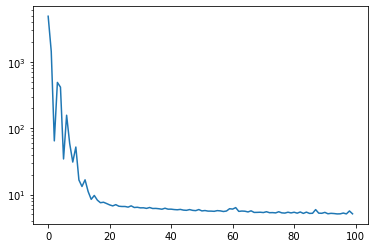

In [58]:
plt.semilogy(info['val_loss'])